In [1]:
import scipy.io as sio
import numpy as np
import os
from os import getcwd
from os.path import join 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

In [2]:
fname = join(os.getcwd(),'data','data3SS2009.mat') # fname = caminho da pasta com arquivo

mat_contents = sio.loadmat(fname) # mat_contents carrega todos os dados do arquivo

dataset = mat_contents['dataset'] # Armazena os dados da coluna dataset

N, Chno, Nc = dataset.shape
# N: number of samples
# Chno: number of channels
# Nc: number of cases

y = mat_contents['labels'].reshape(Nc)

y

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5

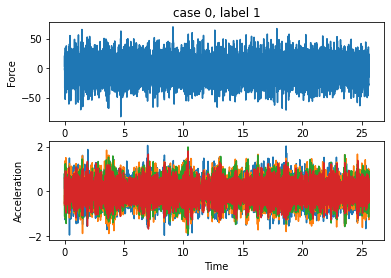

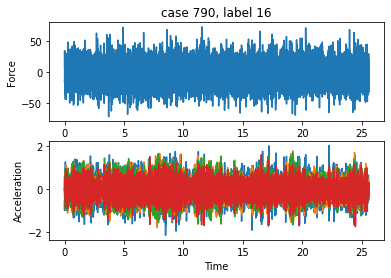

In [3]:
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar

Ts = 3.125 * 1e-3 # sampling time
time = (np.linspace(1,N,N) - 1) * Ts

for case in np.array([0,790]):
    plt.figure(case)
    plt.subplot(211)
    plt.title('case %d, label %d' % (case, y[case]))
    plt.plot(time,Ch1[:,case])
    plt.ylabel('Force')
    plt.subplot(212)
    plt.plot(time,Ch2[:,case],time,Ch3[:,case],time,Ch4[:,case],time,Ch5[:,case])
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.show()

In [4]:
# Exercício 4.a.a

#loop feito para cada canal e cada sequência de medidas
#Importações indicadas no tutorial da página
# https://www.statsmodels.org/devel/generated/statsmodels.tsa.ar_model.AutoReg.html#statsmodels.tsa.ar_model.AutoReg

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg  

Channels = [Ch2, Ch3, Ch4, Ch5]
X1 = []
n_lag = 30

for Channel in Channels:
    parameters = []
    for case in range(Nc):
        AR_Ch = AutoReg(Channel[:,case],lags=n_lag).fit()
        parameters.append(AR_Ch.params)
    parameters = np.vstack(tuple(parameters))
    print('Output shape = {}'.format(parameters.shape))
    X1.append(parameters)

X1 = np.hstack(X1)
X1.shape #Formato da matriz final

Output shape = (850, 31)
Output shape = (850, 31)
Output shape = (850, 31)
Output shape = (850, 31)


(850, 124)

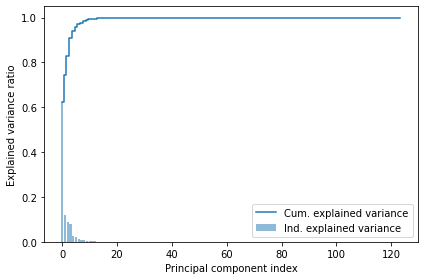

(850, 10)

In [5]:
# Exercício 4.a.b
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X1)

exp_var_pca = pca.explained_variance_ratio_
cum_sum_variance = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center',label='Ind. explained variance')
plt.step(range(0,len(cum_sum_variance)), cum_sum_variance, where='mid', label='Cum. explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

X1_reduced=pca.fit_transform(X1)
componentes=len(cum_sum_variance[cum_sum_variance<0.99])
X2=X1_reduced[:,0:componentes]
X2.shape

# X3 -> T2(T1(X3)) -> OUTPUT (1 a 17)

In [6]:
# Exercício 4.b

# Utilizando métodos descritos em:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler
# E no slide 12 da aula 2

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
X1s = scaler.fit_transform(X1)
X2s = scaler.fit_transform(X2)

indDam = y > 9

dfARed = pd.concat([pd.DataFrame(X1s),pd.DataFrame({'target':indDam})], axis=1)
dfPCA = pd.concat([pd.DataFrame(X2s),pd.DataFrame({'target':indDam})], axis=1)

dfPCA.describe()

0           1           2           3           4           5  \
count  850.000000  850.000000  850.000000  850.000000  850.000000  850.000000   
mean    -0.252236   -0.312300   -0.234238   -0.012273   -0.129277   -0.010447   
std      0.582294    0.450444    0.235347    0.427869    0.369069    0.354312   
min     -1.000000   -1.000000   -1.000000   -1.000000   -1.000000   -1.000000   
25%     -0.820990   -0.605487   -0.402430   -0.285883   -0.381873   -0.189913   
50%     -0.425344   -0.470663   -0.246178    0.038969   -0.206845   -0.028918   
75%      0.352590   -0.222251   -0.077246    0.292005    0.141888    0.149019   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

                6           7           8           9  
count  850.000000  850.000000  850.000000  850.000000  
mean    -0.085838   -0.070841   -0.195128   -0.051741  
std      0.367903    0.350867    0.289218    0.342014  
min     -1.000000   -1.000000   -1.000000   -1.000000  
25%     -0.359643   -0.277146   -0.345575   -0.254795  
50%     -0.119966   -0.071913   -0.167205   -0.007364  
75%      0.141957    0.119499   -0.040920    0.172722  
max      1.000000    1.000000    1.000000    1.000000

In [80]:
# Aula 4 - preparação
# Definições dos modelos
from sklearn.model_selection import (train_test_split, RepeatedKFold, RandomizedSearchCV)
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from scipy import stats
from scipy.stats import loguniform
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from sklearn.metrics import (accuracy_score, mean_squared_error)
import json

models = []
models.append(("LRG",Ridge()))
models.append(("SVR",SVR()))
models.append(("KNN",KNeighborsRegressor()))

nomes_modelos = ["LRG", "SVR", "KNN"]
param_grids = []

param_grids.append( #Logistic Regression
    [
        {
            "LRG__alpha": stats.loguniform(1e-2,1e2),
            "LRG__solver": ["auto"],
        }
        
    ]
)

param_grids.append( #SVR
    [
        {
            "SVR__C": stats.loguniform(1e-1,1e3),
            "SVR__kernel": ["linear","poly","rbf","sigmoid"],
            "SVR__degree": stats.randint(2,5),
            "SVR__gamma": stats.loguniform(1e-4,1e0),
            "SVR__epsilon": stats.loguniform(1e-4,1e1),
        }
        
    ]
)

param_grids.append( #KNN
    [
        {
            "KNN__n_neighbors": stats.randint(2,100),
            "KNN__weights": ["uniform","distance"],
        }
        
    ]
)

In [81]:
# Exercício Aula 4 
# Exercício 1
i=42
pctHoldout = 0.4
kfolds =  5
nkiter = 50
n_search_iter = 10

X_train, X_test, y_train, y_test = train_test_split(X2s,y, test_size=pctHoldout, random_state=i) 



In [82]:
# Exercício aula 4
# Exercício 2.A
for k in range(3):
    rkf = RepeatedKFold(n_splits=5, n_repeats=50, random_state=i)
    clf = Pipeline([("scaler",StandardScaler()),(models[k])])
    param_grid = param_grids[k]
    random_search = RandomizedSearchCV(clf,verbose=0,scoring="neg_mean_squared_error",
        param_distributions=param_grid, n_iter=10,n_jobs=-1,cv=rkf,random_state=i)
    ti = datetime.now()
    random_search.fit(X_train,y_train)
    perf_train = random_search.score(X_train,y_train)
    tf1 = datetime.now()
    random_search.fit(X_test,y_test)
    perf_test = random_search.score(X_test,y_test)
    yh = random_search.predict(X_test)
#     perf_test_final = random_search.score()
    
    print(f"Modelo: {nomes_modelos[k]}\n")
    print(f"Performance no treino = {perf_train:.2f}.")
    print(f"Performance no teste = {perf_test:.2f}.")
#     print(f"performance final = {perf_test_final:.2f}")
    print(f"Demorou {tf1-ti} segundos.\n")
    
    print("Resultados dos parâmetros:")
    for par in random_search.best_params_.keys():
        print(f"Parâmetro {par}: {random_search.best_params_[par]}")
    print("------------------------------------------------------")

Modelo: LRG

Performance no treino = -2.49.
Performance no teste = -2.32.
Demorou 0:00:07.173219 segundos.

Resultados dos parâmetros:
Parâmetro LRG__alpha: 0.314891164795686
Parâmetro LRG__solver: auto
------------------------------------------------------
Modelo: SVR

Performance no treino = -0.56.
Performance no teste = -0.53.
Demorou 0:00:26.939170 segundos.

Resultados dos parâmetros:
Parâmetro SVR__C: 3.9759772143180947
Parâmetro SVR__degree: 4
Parâmetro SVR__epsilon: 0.01906996610300043
Parâmetro SVR__gamma: 0.13826232179369854
Parâmetro SVR__kernel: rbf
------------------------------------------------------
Modelo: KNN

Performance no treino = -0.00.
Performance no teste = -0.00.
Demorou 0:00:04.861973 segundos.

Resultados dos parâmetros:
Parâmetro KNN__n_neighbors: 3
Parâmetro KNN__weights: distance
------------------------------------------------------


In [ ]:
# Exercício aula 4
# Exercício 2.B
# n_iter = 100
for k in range(3):
    t0 = datetime.now()
    rkf = RepeatedKFold(n_splits=5, n_repeats=50, random_state=i)
    clf = Pipeline([("scaler",StandardScaler()),(models[k])])
    param_grid = param_grids[k]
    random_search = RandomizedSearchCV(clf,verbose=0,scoring="neg_mean_squared_error",
        param_distributions=param_grid, n_iter=100,n_jobs=-1,cv=rkf,random_state=i)
    random_search.fit(X_train,y_train)
    perf_train = random_search.score(X_train,y_train)
    random_search.fit(X_test,y_test)
    perf_test = random_search.score(X_test,y_test)
    t1 = datetime.now()
    print(f"Modelo: {nomes_modelos[k]}\n")
    print(f"Performance no treino = {perf_train:.2f}.")
    print(f"Performance no teste = {perf_test:.2f}.")
    print(f"Demorou {t1-t0} segundos.\n")
    
    print("Resultados dos parâmetros:")
    for par in random_search.best_params_.keys():
        print(f"Parâmetro {par}: {random_search.best_params_[par]}")
    print("------------------------------------------------------")

Modelo: LRG

Performance no treino = -2.49.
Performance no teste = -2.32.
Demorou 0:01:06.250568 segundos.

Resultados dos parâmetros:
Parâmetro LRG__alpha: 0.9444574254983555
Parâmetro LRG__solver: auto
------------------------------------------------------


In [83]:
resultados = {}
resultados["LRG"] = {}
resultados["LRG"]["LRG__alpha"] = []
resultados["LRG"]["LRG__solver"] = []
resultados["LRG"]["Train_score"] = []
resultados["LRG"]["Test_score"] = []

resultados["SVR"] = {}
resultados["SVR"]["SVR__C"] = []
resultados["SVR"]["SVR__kernel"] = []
resultados["SVR"]["SVR__degree"] = []
resultados["SVR"]["SVR__gamma"] = []
resultados["SVR"]["SVR__epsilon"] = []
resultados["SVR"]["Train_score"] = []
resultados["SVR"]["Test_score"] = []

resultados["KNN"] = {}
resultados["KNN"]["KNN__n_neighbors"] = []
resultados["KNN"]["KNN__weights"] = []
resultados["KNN"]["Train_score"] = []
resultados["KNN"]["Test_score"] = []

print(json.dumps(resultados, indent=4))




{
    "LRG": {
        "LRG__alpha": [],
        "LRG__solver": [],
        "Train_score": [],
        "Test_score": []
    },
    "SVR": {
        "SVR__C": [],
        "SVR__kernel": [],
        "SVR__degree": [],
        "SVR__gamma": [],
        "SVR__epsilon": [],
        "Train_score": [],
        "Test_score": []
    },
    "KNN": {
        "KNN__n_neighbors": [],
        "KNN__weights": [],
        "Train_score": [],
        "Test_score": []
    }
}


In [84]:
seeds = [3,23,43,73,93] #seeds aleatórias para testar repetibilidade

for s in seeds:
    print(f"random_state={s}")
    for k in range(3):
        rkf = RepeatedKFold(n_splits=5, n_repeats=50, random_state=i)
        clf = Pipeline([("scaler",StandardScaler()),(models[k])])
        param_arq = resultados[nomes_modelos[k]]
        param_grid = param_grids[k]
        random_search = RandomizedSearchCV(clf,verbose=0,scoring="neg_mean_squared_error",
            param_distributions=param_grid, n_iter=10,n_jobs=-1,cv=rkf,random_state=i)
        t0 = datetime.now()
        random_search.fit(X_train,y_train)
        param_arq["Train_score"].append(random_search.score(X_train,y_train))
        t1 = datetime.now()
        random_search.fit(X_test,y_test)
        param_arq["Test_score"].append(random_search.score(X_test,y_test))
        
        print(f"Avaliação do Modelo: {nomes_modelos[k]}\n")
        print(f"Performance no treino = {random_search.score(X_train,y_train):.2f}.")
        print(f"Performance no teste = {random_search.score(X_test,y_test):.2f}.")
        print(f"Demorou {t1-t0} segundos.\n")
    
        print("Resultados dos parâmetros:")
        for par in random_search.best_params_.keys():
            print(f"Parâmetro {par}: {random_search.best_params_[par]}")
            param_arq[par].append(random_search.best_params_[par])
#             resultados[nomes_modelos[k]][par].append(random_search.best_params_[par])
        print("------------------------------------------------------")
        
        

random_state=3
Avaliação do Modelo: LRG

Performance no treino = -2.53.
Performance no teste = -2.32.
Demorou 0:00:03.615336 segundos.

Resultados dos parâmetros:
Parâmetro LRG__alpha: 0.314891164795686
Parâmetro LRG__solver: auto
------------------------------------------------------
Avaliação do Modelo: SVR

Performance no treino = -0.93.
Performance no teste = -0.53.
Demorou 0:00:35.113397 segundos.

Resultados dos parâmetros:
Parâmetro SVR__C: 3.9759772143180947
Parâmetro SVR__degree: 4
Parâmetro SVR__epsilon: 0.01906996610300043
Parâmetro SVR__gamma: 0.13826232179369854
Parâmetro SVR__kernel: rbf
------------------------------------------------------
Avaliação do Modelo: KNN

Performance no treino = -0.54.
Performance no teste = -0.00.
Demorou 0:00:04.005885 segundos.

Resultados dos parâmetros:
Parâmetro KNN__n_neighbors: 3
Parâmetro KNN__weights: distance
------------------------------------------------------
random_state=23
Avaliação do Modelo: LRG

Performance no treino = -2.5

In [87]:
pd.DataFrame(resultados['LRG'])

LRG__alpha LRG__solver  Train_score  Test_score
0    0.314891        auto    -2.488062   -2.323897
1    0.314891        auto    -2.488062   -2.323897
2    0.314891        auto    -2.488062   -2.323897
3    0.314891        auto    -2.488062   -2.323897
4    0.314891        auto    -2.488062   -2.323897

In [88]:
pd.DataFrame(resultados['SVR'])

SVR__C SVR__kernel  SVR__degree  SVR__gamma  SVR__epsilon  Train_score  \
0  3.975977         rbf            4    0.138262       0.01907    -0.556337   
1  3.975977         rbf            4    0.138262       0.01907    -0.556337   
2  3.975977         rbf            4    0.138262       0.01907    -0.556337   
3  3.975977         rbf            4    0.138262       0.01907    -0.556337   
4  3.975977         rbf            4    0.138262       0.01907    -0.556337   

   Test_score  
0   -0.528421  
1   -0.528421  
2   -0.528421  
3   -0.528421  
4   -0.528421

In [89]:
pd.DataFrame(resultados['KNN'])

KNN__n_neighbors KNN__weights  Train_score  Test_score
0                 3     distance         -0.0        -0.0
1                 3     distance         -0.0        -0.0
2                 3     distance         -0.0        -0.0
3                 3     distance         -0.0        -0.0
4                 3     distance         -0.0        -0.0

In [98]:
# Comparando com os defaults

clf_KNN_default = KNeighborsClassifier().fit(X2s,y)
KNN_yh_default = clf_KNN_default.predict(X2s)
prec_KNN_default = accuracy_score(y, KNN_yh_default)
print(f"A precisão do modelo KNN com parâmetros default foi: {prec_KNN_default*100:.2f}%")

clf_KNN_otimizado = KNeighborsClassifier(n_neighbors=3, weights = 'distance').fit(X2s,y)
KNN_yh_otimizado = clf_KNN_otimizado.predict(X2s)
prec_KNN_otimizado = accuracy_score(y, KNN_yh_otimizado)
print(f"A precisão do modelo KNN com parâmetros otimizados foi: {prec_KNN_otimizado*100:.2f}%")


A precisão do modelo KNN com parâmetros default foi: 98.35%
A precisão do modelo KNN com parâmetros otimizados foi: 100.00%


In [111]:
# Comparando com os defaults

clf_SVR_default = SVR().fit(X2s,y)
SVR_yh_default = clf_SVR_default.predict(X2s)
# prec_SVR_default = accuracy_score(y, SVR_yh_default)
# print(f"A precisão do modelo SVR com parâmetros default foi: {prec_SVR_default*100:.2f}%")
prec_SVR_default = mean_squared_error(y, SVR_yh_default)
print(f"A precisão do modelo SVR com parâmetros default foi: {prec_SVR_default}")

clf_SVR_otimizado = SVR(C=3.975977, kernel='rbf',degree=4,gamma=0.138262,epsilon=0.01907).fit(X2s,y)
SVR_yh_otimizado = clf_SVR_otimizado.predict(X2s)
# prec_SVR_otimizado = accuracy_score(y, SVR_yh_otimizado)
# print(f"A precisão do modelo SVR com parâmetros otimizados foi: {prec_SVR_otimizado*100:.2f}%")
prec_SVR_otimizado = mean_squared_error(y, SVR_yh_otimizado)
print(f"A precisão do modelo SVR com parâmetros otimizados foi: {prec_SVR_otimizado}")


A precisão do modelo SVR com parâmetros default foi: 0.7569026606390169
A precisão do modelo SVR com parâmetros otimizados foi: 1.0391098441215187


In [119]:
clf_LRG_default = Ridge(max_iter = 1000).fit(X2s,y)
LRG_yh_default = clf_LRG_default.predict(X2s)
# prec_LRG_default = accuracy_score(y, LRG_yh_default)
# print(f"A precisão do modelo LRG com parâmetros default foi: {prec_LRG_default*100:.2f}%")
prec_LRG_default = mean_squared_error(y, LRG_yh_default)
print(f"A precisão do modelo LRG com parâmetros default foi: {prec_LRG_default}")

clf_LRG_otimizado = Ridge(alpha=0.314891164795686,solver="auto", max_iter = 100).fit(X2s,y)
LRG_yh_otimizado = clf_LRG_otimizado.predict(X2s)
# prec_LRG_otimizado = accuracy_score(y, LRG_yh_otimizado)
# print(f"A precisão do modelo LRG com parâmetros otimizados foi: {prec_LRG_otimizado*100:.2f}%")
prec_LRG_otimizado = mean_squared_error(y, LRG_yh_otimizado)
print(f"A precisão do modelo LRG com parâmetros default foi: {prec_LRG_otimizado}")

A precisão do modelo LRG com parâmetros default foi: 2.4324232806848975
A precisão do modelo LRG com parâmetros default foi: 2.432077193190964
